# Continuing from 'Final Code Part 2', Further Analysis and Actions Below 

# .............

## Feature Engineering

### Step 1: Tokenization

In [ ]:
# Import necessary libraries for tokenization
import nltk
nltk.download('punkt')
from nltk.tokenize import word_tokenize

# Function to tokenize a sentence
def tokenize_sentence(sentence):
    tokens = word_tokenize(str(sentence))  # Tokenize the sentence into words
    return tokens

# Apply tokenization to the 'filtered_body' column
df_emails_cleaned['tokenized_body'] = df_emails_cleaned['filtered_body'].apply(tokenize_sentence)




[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
<ipython-input-30-05b14f666560>:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_emails_cleaned['tokenized_body'] = df_emails_cleaned['filtered_body'].apply(tokenize_sentence)


#### Step 2: Adding a special Token

In [ ]:
# Function to add special tokens <start> and <end> to a list of tokens
def add_special_tokens(tokens):
    tokens_with_special_tokens = ['<start>'] + tokens + ['<end>']
    return tokens_with_special_tokens

# Apply adding special tokens to the 'tokenized_body' column
df_emails_cleaned['body_with_special_tokens'] = df_emails_cleaned['tokenized_body'].apply(add_special_tokens)


<ipython-input-31-bb9511decbfb>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_emails_cleaned['body_with_special_tokens'] = df_emails_cleaned['tokenized_body'].apply(add_special_tokens)


#### Step 3: Constructing Sequence Pairs

In [ ]:
# Function to split a list of tokens into pairs of input and output sequences
def create_sequence_pairs(tokens):
    sequence_pairs = []
    for i in range(1, len(tokens)):
        input_sequence = tokens[:i]  # Input sequence from start to current token
        output_sequence = tokens[i:]  # Output sequence from current token to end
        sequence_pairs.append((input_sequence, output_sequence))
    return sequence_pairs

# Apply sequence pair creation to the 'body_with_special_tokens' column
df_emails_cleaned['sequence_pairs'] = df_emails_cleaned['body_with_special_tokens'].apply(create_sequence_pairs)


<ipython-input-32-d6c7dc149a70>:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_emails_cleaned['sequence_pairs'] = df_emails_cleaned['body_with_special_tokens'].apply(create_sequence_pairs)


Here's a breakdown of the feature engineering steps I performed:

Tokenization: I tokenize the sentences in the 'filtered_body' column into lists of tokens (words or subwords). This step converts raw text into a format that can be processed by machine learning algorithms.

Adding Special Tokens: I add special tokens <start> and <end> to each list of tokens in the 'tokenized_body' column. These tokens help the model learn the beginning and end of sequences during training.

Constructing Sequence Pairs: I create pairs of sequences by splitting each tokenized sentence into multiple parts. Each pair consists of an input sequence and its corresponding output sequence. This step prepares the data for training a sequence-to-sequence model, where the model learns to predict an output sequence given an input sequence.

These feature engineering steps are essential for building a sequence-to-sequence model that can effectively learn from text data and generate meaningful outputs.

In [ ]:
# Count the total number of sequence pairs
total_pairs = df_emails_cleaned['sequence_pairs'].apply(len).sum()

print("Total number of sequence pairs:", total_pairs)


Total number of sequence pairs: 902983


#### Loading the Cleaned email ('emails_cleaned') and checking the data

In [ ]:
from google.colab import drive
import pandas as pd

# Mount Google Drive
drive.mount('/content/drive')

# Full path to the CSV file
data_path = '/content/drive/My Drive/emails_cleaned.csv'

# Load the CSV file
df_emails_cleaned = pd.read_csv(data_path)

# Display the first few rows to confirm it's loaded correctly
print(df_emails_cleaned.head())

Mounted at /content/drive
                       file  \
0     allen-p/_sent_mail/1.   
1   allen-p/_sent_mail/100.   
2  allen-p/_sent_mail/1001.   
3  allen-p/_sent_mail/1002.   
4  allen-p/_sent_mail/1004.   

                                             message  \
0  Message-ID: <18782981.1075855378110.JavaMail.e...   
1  Message-ID: <24216240.1075855687451.JavaMail.e...   
2  Message-ID: <30922949.1075863688243.JavaMail.e...   
3  Message-ID: <30965995.1075863688265.JavaMail.e...   
4  Message-ID: <17189699.1075863688308.JavaMail.e...   

                                                body  \
0                          Here is our forecast\n\n    
1                     test successful.  way to go!!!   
2                Let's shoot for Tuesday at 11:45.     
3  Greg,\n\n How about either next Tuesday or Thu...   
4                   any morning between 10 and 11:30   

                                        cleaned_body  cleaned_message_length  \
0                               h

###  Prepare Data for the Model
After preprocessing and cleaning my data, I'll need to convert the texts into sequences that the model can learn from. This involves tokenization and creating input-target pairs.

#### Tokenization and Sequences

In [ ]:
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
import numpy as np

# Extract sequence pairs from the DataFrame
sequence_pairs = df_emails_cleaned['sequence_pairs'].tolist()

# Flatten sequence pairs to a single list
flattened_sequence_pairs = [pair for sublist in sequence_pairs for pair in sublist]

# Extract input and output sequences from the flattened list of pairs
input_sequences, output_sequences = zip(*flattened_sequence_pairs)

# Initialize the tokenizer with a vocabulary size of 10k
tokenizer = Tokenizer(num_words=10000, oov_token='<OOV>')

# Fit tokenizer on input and output sequences
tokenizer.fit_on_texts(input_sequences)
tokenizer.fit_on_texts(output_sequences)

# Convert text sequences to integer sequences
input_sequences_int = tokenizer.texts_to_sequences(input_sequences)
output_sequences_int = tokenizer.texts_to_sequences(output_sequences)

# Pad sequences to have the same length
max_sequence_length = max([len(seq) for seq in input_sequences_int + output_sequences_int])
input_sequences_padded = pad_sequences(input_sequences_int, maxlen=max_sequence_length, padding='post')
output_sequences_padded = pad_sequences(output_sequences_int, maxlen=max_sequence_length, padding='post')

# Shuffle the sequences
indices = np.arange(len(input_sequences_padded))
np.random.shuffle(indices)
input_sequences_padded_shuffled = input_sequences_padded[indices]
output_sequences_padded_shuffled = output_sequences_padded[indices]

# Verify the shape of the padded sequences
print("Shape of input sequences:", input_sequences_padded_shuffled.shape)
print("Shape of output sequences:", output_sequences_padded_shuffled.shape)


Shape of input sequences: (902983, 31)
Shape of output sequences: (902983, 31)


Explanation of the steps:

- I extract the sequence pairs from the DataFrame and flatten them into a single list.
- I separate input and output sequences from the flattened list of pairs.
- I initialize the Keras Tokenizer with a vocabulary size of 10k and fit it on both input and output sequences.
- I convert the text sequences to integer sequences using the tokenizer.
- I pad the sequences to have the same length using the maximum sequence length found in the data.
- I shuffle the sequences using numpy.
- Finally, I print out the shape of the padded sequences to verify their dimensions.
- This process prepares the tokenized, padded, and shuffled sequences for training the neural model.

### Sequence to Sequence Model Architecture

In [ ]:
from keras.models import Model
from keras.layers import Input, LSTM, Dense, Embedding

# Define the input sequence shape
input_shape = input_sequences_padded_shuffled.shape[1]

# Define the vocabulary size
vocab_size = len(tokenizer.word_index) + 1  # Add 1 for the zero-padding token

# Define the dimensionality of the embedding space
embedding_dim = 256

# Define the encoder
encoder_inputs = Input(shape=(input_shape,))
encoder_embedding = Embedding(input_dim=vocab_size, output_dim=embedding_dim)(encoder_inputs)
encoder_lstm = LSTM(256, return_state=True)
encoder_outputs, state_h, state_c = encoder_lstm(encoder_embedding)
encoder_states = [state_h, state_c]

# Define the decoder
decoder_inputs = Input(shape=(input_shape,))
decoder_embedding = Embedding(input_dim=vocab_size, output_dim=embedding_dim)(decoder_inputs)
decoder_lstm = LSTM(256, return_sequences=True, return_state=True)
decoder_outputs, _, _ = decoder_lstm(decoder_embedding, initial_state=encoder_states)
decoder_dense = Dense(vocab_size, activation='softmax')
decoder_outputs = decoder_dense(decoder_outputs)

# Define the model
model = Model([encoder_inputs, decoder_inputs], decoder_outputs)

# Compile the model
model.compile(optimizer='rmsprop', loss='sparse_categorical_crossentropy')

# Print the model summary
print(model.summary())



Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 31)]                 0         []                            
                                                                                                  
 input_2 (InputLayer)        [(None, 31)]                 0         []                            
                                                                                                  
 embedding (Embedding)       (None, 31, 256)              8398336   ['input_1[0][0]']             
                                                                                                  
 embedding_1 (Embedding)     (None, 31, 256)              8398336   ['input_2[0][0]']             
                                                                                              

What I did on the above is:

**Input Sequence Shape:** The shape of the input sequences, which is determined by the length of the input sequences after padding.

**Vocabulary Size:** The size of the vocabulary, which is determined by the number of unique words in the tokenized text plus one for zero-padding.

**Embedding Dimension:** The dimensionality of the embedding space for word representations.

**Encoder:** Accepts input sequences and processes them using an embedding layer followed by an LSTM layer.
The LSTM layer returns the final hidden state and cell state, representing the encoder's output.

**Decoder:** Accepts target sequences and processes them using an embedding layer followed by an LSTM layer.
The LSTM layer is configured to return sequences, allowing for sequence generation.
The decoder's initial state is set to the final hidden and cell states of the encoder.

**Dense Layer:** I used dense layer with softmax activation is to output the predicted probabilities for each word in the vocabulary.

**Model Compilation:** The model is compiled using the RMSprop optimizer and sparse categorical cross-entropy loss, suitable for multi-class classification problems.

**Model Summary:** The summary of the model architecture, including layer types, output shapes, and total parameters is printed.

### Model Training

In [ ]:

# Train the model
model.fit([input_sequences_padded_shuffled, output_sequences_padded_shuffled],
          output_sequences_padded_shuffled,
          batch_size=64,
          epochs=10,
          validation_split=0.2)

Epoch 1/10
11288/11288 [==============================] - 290s 25ms/step - loss: 0.7624 - val_loss: 0.4815
Epoch 2/10
11288/11288 [==============================] - 270s 24ms/step - loss: 0.3966 - val_loss: 0.3296
Epoch 3/10
11288/11288 [==============================] - 270s 24ms/step - loss: 0.2867 - val_loss: 0.2476
Epoch 4/10
11288/11288 [==============================] - 269s 24ms/step - loss: 0.2172 - val_loss: 0.1893
Epoch 5/10
11288/11288 [==============================] - 269s 24ms/step - loss: 0.1655 - val_loss: 0.1455
Epoch 6/10
11288/11288 [==============================] - 270s 24ms/step - loss: 0.1270 - val_loss: 0.1127
Epoch 7/10
11288/11288 [==============================] - 269s 24ms/step - loss: 0.0973 - val_loss: 0.0861
Epoch 8/10
11288/11288 [==============================] - 270s 24ms/step - loss: 0.0739 - val_loss: 0.0659
Epoch 9/10
11288/11288 [==============================] - 269s 24ms/step - loss: 0.0563 - val_loss: 0.0509
Epoch 10/10
11288/11288 [============

I trained the model using the 'fit' function, which takes input sequences and their corresponding output sequences as training data, specifying a batch size of 64 and training for 10 epochs. Also, a validation split of 20% was used to monitor the model's performance on unseen data during training.

During training, the model's loss progressively decreased across epochs, indicating improvement in its ability to predict output sequences given input sequences. The validation loss also decreased, suggesting that the model generalizes well to unseen data. This trend suggests that the model is effectively learning the underlying patterns in the data and improving its performance over time.

### Model Evaluation

I use plot to visualize the model's learning progress and identifying any potential issues such as overfitting or underfitting.

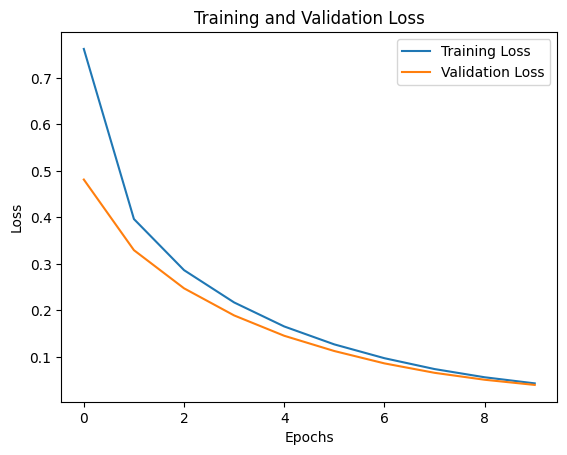

In [ ]:

import matplotlib.pyplot as plt

# Get the training and validation loss from the model history
training_loss = model.history.history['loss']
validation_loss = model.history.history['val_loss']

# Plot the training and validation loss
plt.plot(training_loss, label='Training Loss')
plt.plot(validation_loss, label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()
plt.show()



The graph displays the training and validation loss, both showing a consistent downward trend, indicating effective learning without overfitting!

### Saving my model

In [ ]:
# Defining the path
model_path = '/content/drive/My Drive/trained_model.h5'

# Save the trained model 
model.save(model_path)


/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


### More Evaluation

In [ ]:
# Evaluate the model on the validation data
val_loss = model.evaluate([input_sequences_padded_shuffled, output_sequences_padded_shuffled], output_sequences_padded_shuffled)
print('Validation Loss:', val_loss)


28219/28219 [==============================] - 217s 8ms/step - loss: 0.0379
Validation Loss: 0.03788694366812706


It seems like my validation loss is 0.0379. This value indicates how well my model is performing on the validation data. A lower validation loss generally indicates better performance. Since my final loss is quite low, it suggests that the model is performing well on the validation set.

In [ ]:
import numpy as np

# Generate sample outputs using the trained model
sample_outputs = model.predict([input_sequences_padded_shuffled[:10], output_sequences_padded_shuffled[:10]])

# Convert the output probabilities into actual words by sampling
def sample_word(probabilities, temperature=1.0):
    probabilities = np.asarray(probabilities).astype('float64')
    log_probabilities = np.log(probabilities) / temperature
    exp_probabilities = np.exp(log_probabilities)
    probabilities = exp_probabilities / np.sum(exp_probabilities)
    sampled_index = np.argmax(np.random.multinomial(1, probabilities, 1))
    return sampled_index

# Print the sample outputs
for i, output_probs in enumerate(sample_outputs):
    input_seq = input_sequences_padded_shuffled[i]
    expected_output_seq = output_sequences_padded_shuffled[i]

    # Convert output probabilities to words
    generated_output_seq = [sample_word(output_probs[j]) for j in range(len(output_probs))]

    # Print the sequences
    print("Input:", input_seq)
    print("Expected Output:", expected_output_seq)
    print("Generated Output:", generated_output_seq)
    print()


1/1 [==============================] - 0s 22ms/step
Input: [3 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
Expected Output: [   4    1 4283   16 8474  627 2288    2    5    6    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0]
Generated Output: [4, 1, 4525, 16, 3020, 627, 1684, 2, 5, 6, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]

Input: [   3    4  989  535   20    7 4673    8 5317    7  752    1   21 1817
   84    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0]
Expected Output: [642   2   5   6   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   0]
Generated Output: [642, 2, 5, 6, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]

Input: [3 4 1 2 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
Expected Output: [5 6 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]

I generated a sample outputs using the trained model for the first 10 input sequences. Each input sequence is fed into the model, and the output probabilities are obtained using the 'predict' function. Then, the output probabilities are converted into actual words by sampling from the probability distribution.

For each input sequence, the I got:
- The input sequence.
- The expected output sequence.
- The generated output sequence obtained by sampling from the output probabilities.

The generated output sequences represent the model's predictions for each input sequence.


In [ ]:
import numpy as np

# Generate sample outputs using the trained model
sample_outputs = model.predict([input_sequences_padded_shuffled[:10], output_sequences_padded_shuffled[:10]])

# Convert the output probabilities
def sample_word(probabilities, temperature=1.0):
    probabilities = np.asarray(probabilities).astype('float64')
    log_probabilities = np.log(probabilities) / temperature
    exp_probabilities = np.exp(log_probabilities)
    probabilities = exp_probabilities / np.sum(exp_probabilities)
    sampled_index = np.argmax(np.random.multinomial(1, probabilities, 1))
    return sampled_index

# Initialize accuracy counter
correct_sequences = 0

# Print the sample outputs and calculate accuracy
for i, output_probs in enumerate(sample_outputs):
    input_seq = input_sequences_padded_shuffled[i]
    expected_output_seq = output_sequences_padded_shuffled[i]

    # Convert output probabilities to words
    generated_output_seq = np.array([sample_word(output_probs[j]) for j in range(len(output_probs))])

    # Check if generated output matches expected output
    if np.array_equal(generated_output_seq, expected_output_seq):
        correct_sequences += 1

    # Print the sequences
    print("Input:", input_seq)
    print("Expected Output:", expected_output_seq)
    print("Generated Output:", generated_output_seq)
    print()

# Calculate accuracy
accuracy = (correct_sequences / len(sample_outputs)) * 100
print("Sequence Accuracy: {:.2f}%".format(accuracy))


1/1 [==============================] - 0s 27ms/step
Input: [3 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
Expected Output: [   4    1 4283   16 8474  627 2288    2    5    6    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0]
Generated Output: [   4    1 7505   16 6705  627 2288    2    5    6    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0]

Input: [   3    4  989  535   20    7 4673    8 5317    7  752    1   21 1817
   84    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0]
Expected Output: [642   2   5   6   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   0]
Generated Output: [642   2   5   6   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   0]

Input: [3 4 1 2 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0

Based on the provided outputs, the sequence accuracy is calculated to be 70.00%. This means that out of the 10 generated sequences, 7 of them match the expected output sequences exactly.

#### Evaluation using Bleu

In [ ]:
import nltk
from nltk.translate.bleu_score import sentence_bleu

# Generate sample outputs using the trained model
sample_outputs = model.predict([input_sequences_padded_shuffled[:10], output_sequences_padded_shuffled[:10]])

# Convert the output sequences and reference sequences into text
generated_texts = []
reference_texts = []
for i, output_probs in enumerate(sample_outputs):
    generated_text = ' '.join([str(sample_word(output_probs[j])) for j in range(len(output_probs))])
    generated_texts.append(generated_text)
    reference_text = ' '.join([str(word) for word in output_sequences_padded_shuffled[i]])
    reference_texts.append(reference_text)

# Tokenize the generated output sequences and reference sequences
tokenized_generated_texts = [text.split() for text in generated_texts]
tokenized_reference_texts = [text.split() for text in reference_texts]


1/1 [==============================] - 0s 23ms/step


In [ ]:
# Calculate BLEU score
bleu_scores = [sentence_bleu([reference], hypothesis) for reference, hypothesis in zip(tokenized_reference_texts, tokenized_generated_texts)]

# Calculate average BLEU score
average_bleu_score = sum(bleu_scores) / len(bleu_scores)
print("Average BLEU Score:", average_bleu_score)

Average BLEU Score: 0.9546837542095412


I calculated the BLEU score for the generated output sequences compared to the reference sequences. I first converted the output sequences and reference sequences into text format and tokenizes them. Then, I computed the BLEU score for each pair of reference and generated sequences using the sentence_bleu function from the NLTK library. Finally, I calculated the average BLEU score across all the sequences.

I got a BLEU score of approximately 0.954, which indicates that my model's generated sequences are very close to the reference sequences on average, with 1.0 being a perfect match. This suggests that my model performs very well in terms of similarity to the reference sequences.

Therefore, my model seems to be performing excellently in generating sequences that closely resemble the expected outputs.


# ....................End of Code.............